In [15]:
import json
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
from datetime import datetime
from wordcloud import WordCloud


In [16]:
EPOCHS = 5
LIMIT = 100 # 500, 1000 , 1500 , 3000
PREDICTION_THRESHOLD = 0.5

In [17]:
f = open('reports_fixed.json')
json_data = json.load(f)
f.close()

all_MeSH = []
all_words = []
max_sentence_length = 0
all_lengths = []

for i in json_data:
  MeSH = str (json_data[i]['MeSH']).lower()
  MeSH_list = MeSH.split(';')
  all_MeSH.extend(MeSH_list)

vectorize_layer = layers.TextVectorization(
  # standardize='lower_and_strip_punctuation',
  standardize='lower',
  split=None,
)
vectorize_layer.adapt(all_MeSH)

entities_vocabulary = vectorize_layer.get_vocabulary()

X = []
Y = []

for i in json_data:
  findings = str (json_data[i]['findings']).lower()
  impression = str (json_data[i]['impression']).lower()
  MeSH = str (json_data[i]['MeSH']).lower()

  MeSH_list = MeSH.split(';')
  sentence = findings + '. ' + impression
  sentence_splitted = sentence.split(' ')
  all_words.extend(sentence_splitted)
  if len(sentence_splitted) > max_sentence_length :
    all_lengths.append(len(sentence_splitted))
    max_sentence_length = len(sentence_splitted)

  entities = [0] * vectorize_layer.vocabulary_size()
  for m in MeSH_list :
    ent_id = entities_vocabulary.index(m)
    entities[ent_id] = 1
  
  X.append(sentence)
  Y.append(entities)

  if len(X) > LIMIT :
    break

In [18]:
# vectorize_layer.get_vocabulary()
# df = pd.DataFrame(all_MeSH)
# df.drop_duplicates(inplace = True)
# df

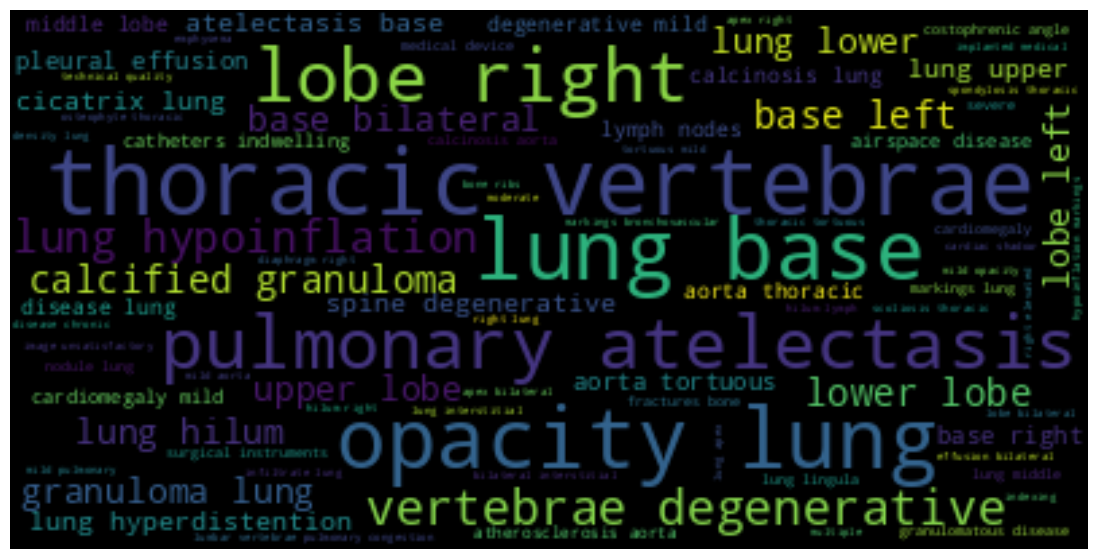

In [19]:
# Create and generate a word cloud image:
compine_string=(" ").join(all_MeSH)

wordcloud = WordCloud().generate(compine_string)

# Display the generated image:
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

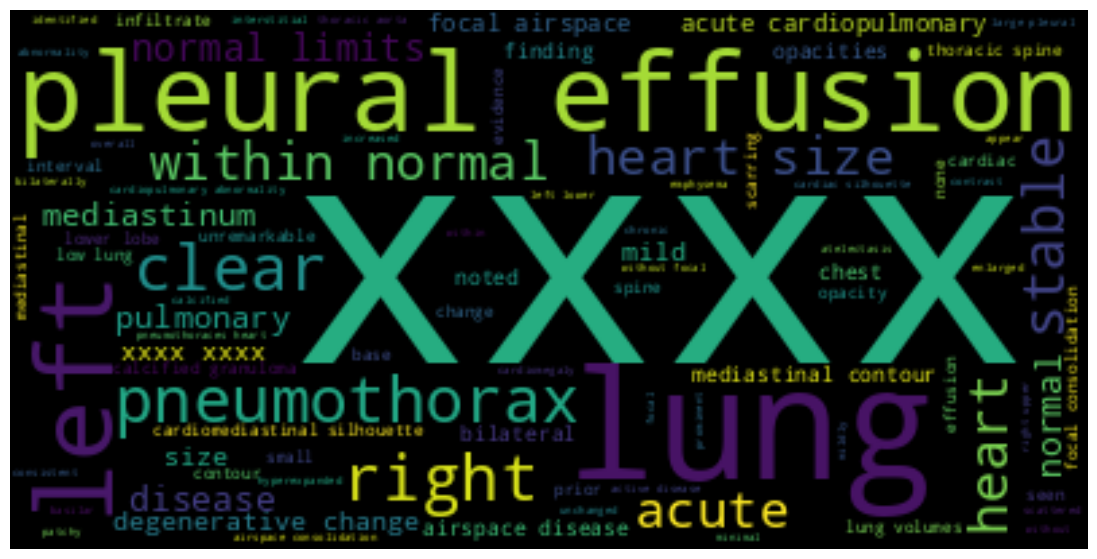

In [20]:
# Create and generate a word cloud image:
compine_string=(" ").join(all_words)

wordcloud = WordCloud().generate(compine_string)

# Display the generated image:
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
# total 2472
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(f'X_train size {len(X_train)}')
print(f'X_test size {len(X_test)}')
print(f'y_train size {len(y_train)}')
print(f'y_test size {len(y_test)}')
print(f'max_sentence_length {(max_sentence_length)}')
max_sentence_length

X_train size 67
X_test size 34
y_train size 67
y_test size 34
max_sentence_length 124


124

<AxesSubplot:xlabel='0'>

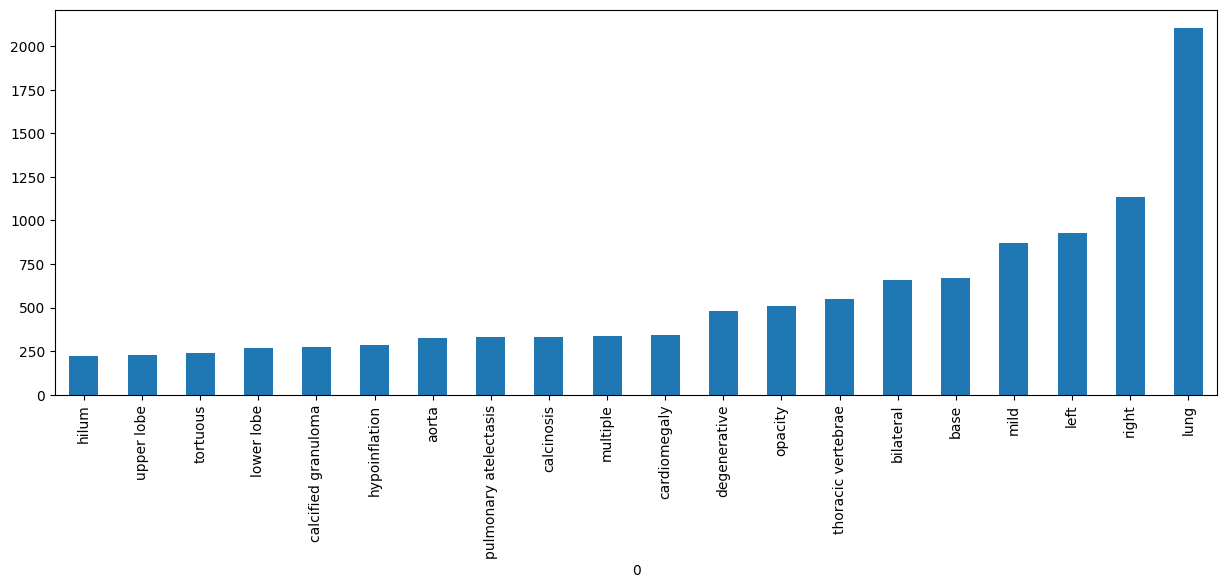

In [22]:
#entities chart
mesh_df=pd.DataFrame(all_MeSH)
tags_grouped = mesh_df.groupby(mesh_df[0])
mesh_df=tags_grouped.size().sort_values()
mesh_df = mesh_df.tail(20)
mesh_df.plot.bar(figsize=(15,5))
# for b in mesh_df.keys():
    # print(f"{b} : {mesh_df[b]}")
# mesh_df

<AxesSubplot:xlabel='0'>

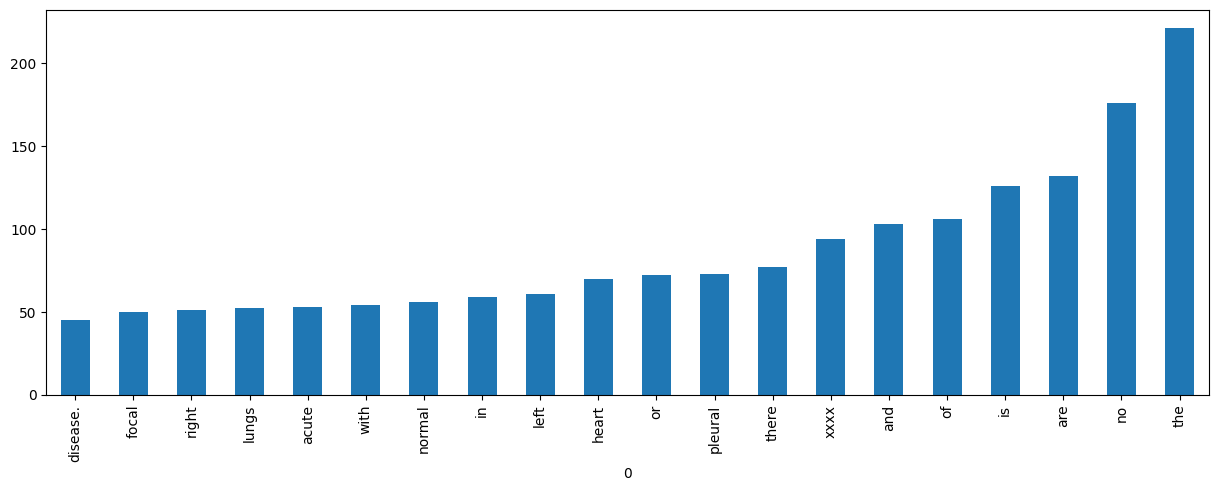

In [23]:
#words chart
words_df=pd.DataFrame(all_words)
tags_grouped = words_df.groupby(words_df[0])
words_df=tags_grouped.size().sort_values()
words_df = words_df.tail(20)
words_df.plot.bar(figsize=(15,5))
# for b in mesh_df.keys():
    # print(f"{b} : {mesh_df[b]}")
# mesh_df

In [24]:
bert_preprocess = hub.load(
  'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4",
    trainable=False)

In [25]:
def get_X_berted(X):
  tok = bert_preprocess.tokenize(X)
  text_preprocessed = bert_preprocess.bert_pack_inputs([tok], max_sentence_length)
  return {
    'input_word_ids': text_preprocessed['input_word_ids'],
    'input_mask': text_preprocessed['input_mask'],
    'input_type_ids': text_preprocessed['input_type_ids'],
  }

In [26]:
X_train_berted = get_X_berted(X_train)
X_test_berted = get_X_berted(X_test)

In [27]:
class DiceLoss(tf.keras.losses.Loss):
  def __init__(self, smooth=1e-6, gama=2):
    super(DiceLoss, self).__init__()
    self.name = 'NDL'
    self.smooth = smooth
    self.gama = gama

  def call(self, y_true, y_pred):
    y_true, y_pred = tf.cast(
        y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * \
        tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
    denominator = tf.reduce_sum(
        y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
    result = 1 - tf.divide(nominator, denominator)
    return result

In [28]:
def create_radenex_model():
  input_ids = layers.Input(shape=(max_sentence_length,), dtype=tf.int32)
  token_type_ids = layers.Input(shape=(max_sentence_length,), dtype=tf.int32)
  attention_mask = layers.Input(shape=(max_sentence_length,), dtype=tf.int32)

  embedding = encoder(
    dict(input_word_ids=input_ids,input_mask=attention_mask,input_type_ids=token_type_ids),
  training=False,
  )["sequence_output"]

  bilstm = layers.Bidirectional(
    layers.LSTM(50, return_sequences=True,
    )
  )(embedding)

  avg1 = layers.AveragePooling1D(pool_size=64,strides=4,padding='same')(bilstm)

  flt = layers.Flatten()(avg1)

  dropout_layer1 = layers.Dropout(0.25)(flt)

  output_layer = layers.Dense(vectorize_layer.vocabulary_size(), activation='sigmoid')(dropout_layer1)

  model = tf.keras.Model(
    inputs = [input_ids, attention_mask, token_type_ids, ],
    outputs = [output_layer],
  )
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy' ) #categorical_crossentropy binary_crossentropy
  print(model.summary())
  # tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)
  return model

radenex = create_radenex_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 124)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 124)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 124)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'sequence_output':  108310273   ['input_6[0][0]',                
                                 (None, 124, 768),                'input_5[0][0]',          

In [29]:
# Create a callback that saves the model's weights
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
            min_delta=1e-3 , # Minimum change in the monitored quantity to qualify as an improvement
             baseline = 0.8) # will stop if stays above baseline

Epoch 1/5


2022-10-20 23:37:06.512665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


2/2 [==============================] - 13s 3s/step - loss: 0.6019 - val_loss: 0.2453
Epoch 2/5
2/2 [==============================] - 3s 2s/step - loss: 0.2169 - val_loss: 0.1032
Epoch 3/5
2/2 [==============================] - 3s 2s/step - loss: 0.1383 - val_loss: 0.1154
Epoch 4/5
2/2 [==============================] - 3s 2s/step - loss: 0.1493 - val_loss: 0.1247
Epoch 5/5
2/2 [==============================] - 3s 2s/step - loss: 0.1497 - val_loss: 0.1252


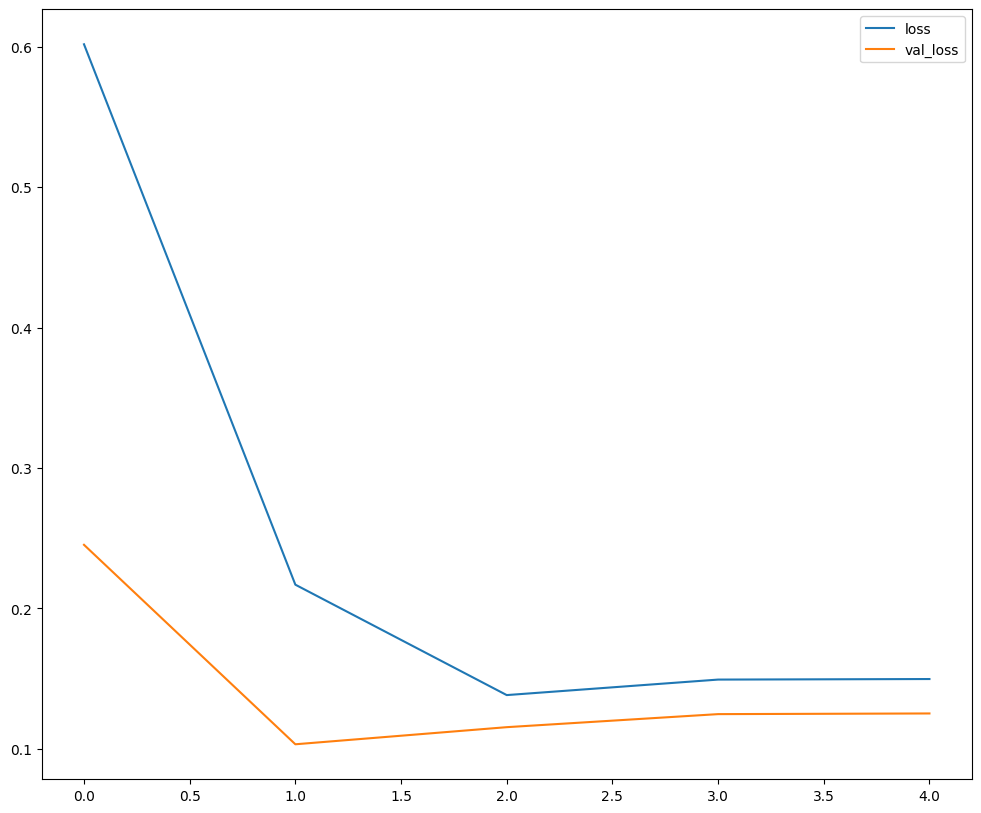

In [30]:
training_history = radenex.fit(
      x=[X_train_berted['input_word_ids'], X_train_berted['input_mask'], X_train_berted['input_type_ids'], ],
      y=np.array(y_train),
      epochs=EPOCHS,
      validation_split=0.05,
      verbose=1,
      callbacks=[callback, ],
      # workers=WORKERS,
      # use_multiprocessing = True,
              )
pd.DataFrame(training_history.history).plot(figsize=(12, 10))
plt.savefig('history/h_'+datetime.now().strftime('%Y-%m-%d-%H:%M')+'.png')

In [31]:
def evaluate1d_old(test_Y,predicted):
  TP = 0
  TN = 0
  FP = 0
  FN = 0
  failed_samples = []
  for i in range(len(predicted)):
    for j in range(len(predicted[i])):
      if float( predicted[i][j] ) >= PREDICTION_THRESHOLD and test_Y[i][j] == 1 :
        TP += 1
      elif float( predicted[i][j] ) < PREDICTION_THRESHOLD and test_Y[i][j] == 1 :
        FP += 1
        failed_samples.append(i)
      elif float( predicted[i][j] ) >= PREDICTION_THRESHOLD and test_Y[i][j] == 0 :
        FN += 1
        failed_samples.append(i)
      else:
        TN +=1
  print('TP , TN , FP , FN:',TP , TN , FP , FN)
  if TP == 0 or TN == 0 or FP == 0 or FN == 0 :
    return None
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = (2 * precision * recall) / (precision + recall)
  print('accuracy,precision,recall,f1',accuracy,precision,recall,f1)
  return failed_samples

In [33]:
predicted = radenex.predict(
      x=[X_test_berted['input_word_ids'], X_test_berted['input_mask'], X_test_berted['input_type_ids'], ], )
res = evaluate1d_old(y_test,predicted)


2/2 [==============================] - 2s 2s/step
TP , TN , FP , FN: 29 5944 172 43
accuracy,precision,recall,f1 0.9652553329023917 0.14427860696517414 0.4027777777777778 0.21245421245421248
